In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob
import random

from skimage import data
from skimage.feature import match_template

import sys
from paths import Paths
paths = Paths()
sys.path.append(paths.scripts_root)
import util
import ip_routines as ip

import imutils

%load_ext autoreload
%autoreload 2

# Display entire width of browser
from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

paths.print_paths()

Paths defined in paths module:
 paths.data_root: /Users/trafferty/data
 paths.notebook_root: /Users/trafferty/data/notebooks
 paths.scripts_root: /Users/trafferty/data/scripts
 paths.images_root: /Users/trafferty/data/images
 paths.projects_root: /Users/trafferty/data/projects
 paths.results_root: /Users/trafferty/data/results
 paths.tmp_root: /Users/trafferty/data/tmp
 paths.dat_root: /Users/trafferty/data/dat
 paths.tmp_dir: /Users/trafferty/tmp
 paths.ws_dir: /Users/trafferty/workspace
 paths.mii_home: /Users/trafferty/dev
 paths.inhouse: /Users/trafferty/dev/src/inhouse


Rows: 140, Cols: 140


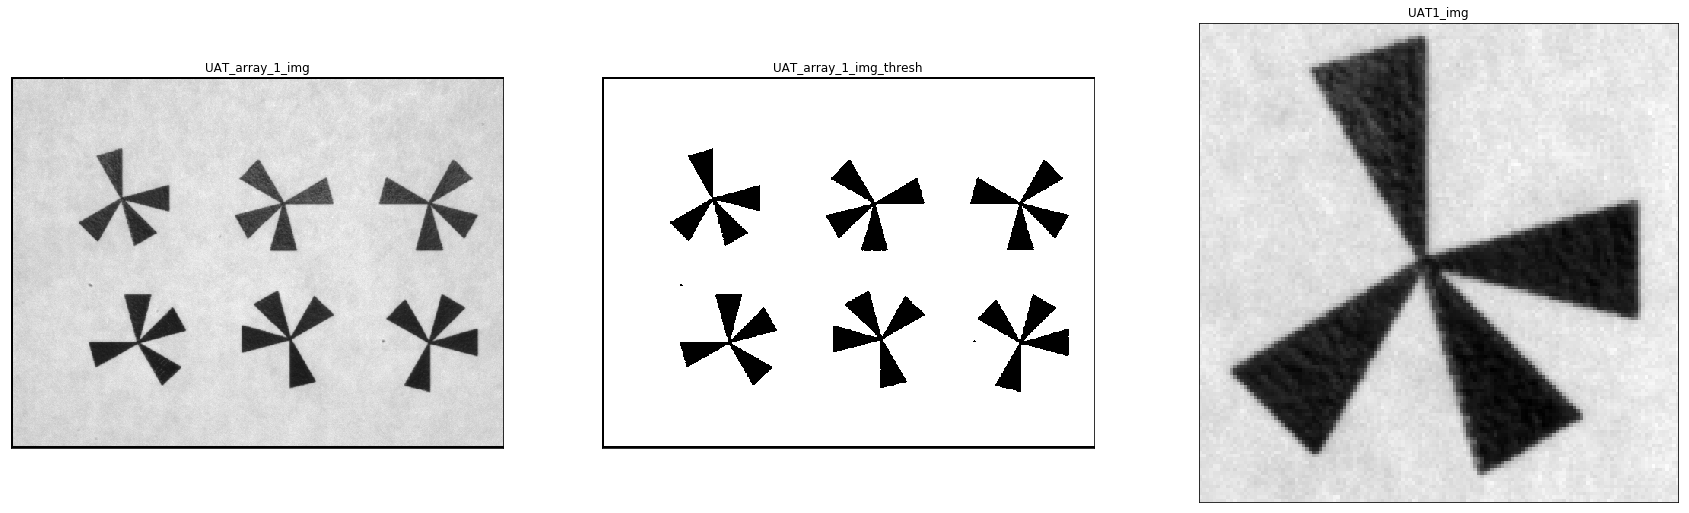

In [2]:
UAT_array_1_img = cv2.imread(paths.images_root+'/uat/UAT_array_01.png', cv2.IMREAD_GRAYSCALE)
UAT_array_2_img = cv2.imread(paths.images_root+'/uat/UAT_array_02.png', cv2.IMREAD_GRAYSCALE)

UAT_array_1_img_thresh = ip.faster_bradley_threshold(UAT_array_1_img, threshold=75, window_r=25)

UAT1_img = UAT_array_1_img_thresh[90:230, 80:220] #np slice: [startY:endY, startX:endX]
UAT1_img = UAT_array_1_img[90:230, 80:220] #np slice: [startY:endY, startX:endX]

rows, cols = UAT1_img.shape
print(f"Rows: {rows}, Cols: {cols}")
midX, midY = int(cols/2), int(rows/2)
l = int(min([rows,cols]) * 0.2)
# cv2.line(UAT1_img, (midX, midY-l), (midX, midY+l), util.green, 1)
# cv2.line(UAT1_img, (midX-l, midY), (midX+l, midY), util.green, 1)

util.plot_imgs([(UAT_array_1_img,'UAT_array_1_img'), (UAT_array_1_img_thresh,'UAT_array_1_img_thresh'), (UAT1_img,'UAT1_img')], max_cols = 3)

### Find Harris Corners

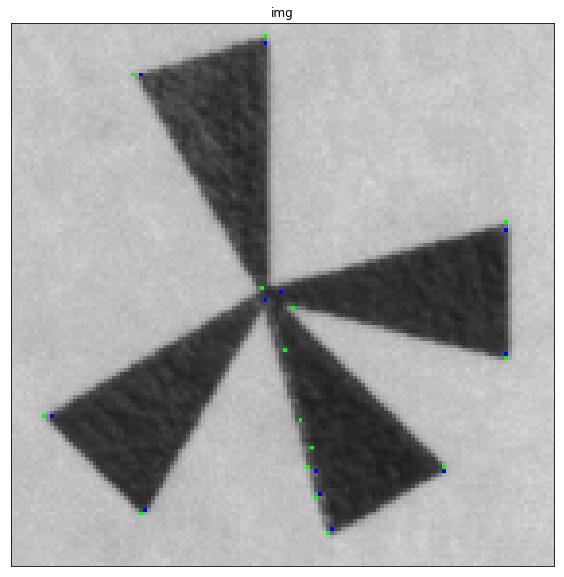

In [3]:
img = cv2.cvtColor(UAT1_img,cv2.COLOR_GRAY2BGR)

# find Harris corners
gray = np.float32(UAT1_img)
dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)
ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
dst = np.uint8(dst)

# find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

# define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

# Now draw them
res = np.hstack((centroids,corners))
res = np.int0(res)
img[res[:,1],res[:,0]]=[0,0,255]
img[res[:,3],res[:,2]] = [0,255,0]

util.plot_imgs([(img,'img')], max_cols = 3)

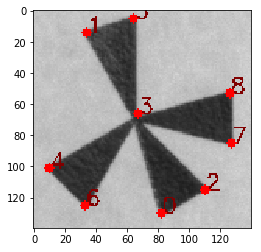

In [4]:
img = cv2.cvtColor(UAT1_img,cv2.COLOR_GRAY2BGR)

corners = cv2.goodFeaturesToTrack(UAT1_img,25,0.01,10)
corners = np.int0(corners[:9])

for idx, i in enumerate(corners):
    x,y = i.ravel()
    cv2.putText(img, str(idx), (x,y), cv2.FONT_HERSHEY_DUPLEX, 0.5, util.navy, 1)
    cv2.circle(img,(x,y),3,255,-1)

plt.imshow(img)
plt.show()

[[125. 125.]
 [237. 153.]
 [237.  97.]]


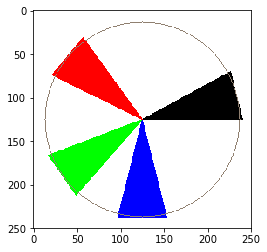

In [5]:
image = np.ones((250, 250, 3), np.uint8) * 255
rows, cols, chan = image.shape
midX, midY = int(cols/2), int(rows/2)

offset = (0, 0)
origin = (midX+offset[0], midY+offset[1]) 
UAT_length = int(np.min([rows, cols]) * 0.45)
UAT_height = int(UAT_length/2.0)

pt1 = (origin[0], origin[1])
pt2 = (pt1[0]+UAT_length, pt1[1]+(UAT_height/2.0))
pt3 = (pt2[0], pt1[1]-(UAT_height/2.0))

triangle_cnt = np.array( [pt1, pt2, pt3] )
print(triangle_cnt)

t2 = util.rotate2D(triangle_cnt, np.array([pt1]), np.radians(220)).astype(int)


angs = [np.radians(-28/2), np.radians(90), np.radians(145), np.radians(220)]
colors = [util.black, util.blue, util.green, util.red]

for color, ang in zip(colors,angs):
    t = util.rotate2D(triangle_cnt, np.array([pt1]), ang).astype(int)
    cv2.drawContours(image, [t], 0, color, -1)

cv2.circle(image, pt1, UAT_length, util.gray, 1) 
#cv2.drawContours(image, [t2], 0, (0,0,255), -1)

plt.imshow(image)
plt.show()

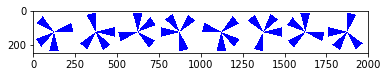

In [6]:
def make_UAT(image_shape, orientation, color=util.black):
    image = np.ones(image_shape, np.uint8) * 255 # all-white, 8-bit image

    if len(image.shape) == 2:
        rows, cols = image.shape
        color=util.black
    else:
        rows, cols, chan = image.shape
    midX, midY = int(cols/2), int(rows/2)

    offset = (0, 0)
    origin = (midX+offset[0], midY+offset[1]) 
    UAT_length = int(np.min([rows, cols]) * 0.45)
    UAT_height = int(UAT_length/2.0)

    pt1 = (origin[0], origin[1])
    pt2 = (pt1[0]+UAT_length, pt1[1]+(UAT_height/2.0))
    pt3 = (pt2[0], pt1[1]-(UAT_height/2.0))

    triangle_pnts = np.array( [pt1, pt2, pt3] )

    angles = [np.radians(-14), np.radians(90), np.radians(145), np.radians(220)]

    for ang in angles:
        t = util.rotate2D(triangle_pnts, np.array([pt1]), ang).astype(int)
        cv2.drawContours(image, [t], 0, color, -1)

    if orientation > 4:
        image = np.flip(image, 1)

    image = np.rot90(image, ((orientation-1)%4))

    return image

base_image = np.ones((250, 0, 3), np.uint8) * 255
for i in range(1,9):
    image = make_UAT((250, 250, 3), i, util.blue)
    base_image = np.concatenate((base_image, image), axis=1)
    
plt.imshow(base_image)
plt.show()

In [7]:
np.min([rows, cols])

250

In [8]:
for i in range(1,9):
    do_flip = True if i > 4 else False
    print(f"[{i}]: Flip={do_flip}, Rot={((i-1)%4)}")

    

[1]: Flip=False, Rot=0
[2]: Flip=False, Rot=1
[3]: Flip=False, Rot=2
[4]: Flip=False, Rot=3
[5]: Flip=True, Rot=0
[6]: Flip=True, Rot=1
[7]: Flip=True, Rot=2
[8]: Flip=True, Rot=3


### UAT Extraction Utilities

Image dims after scaling: (1294, 2535)


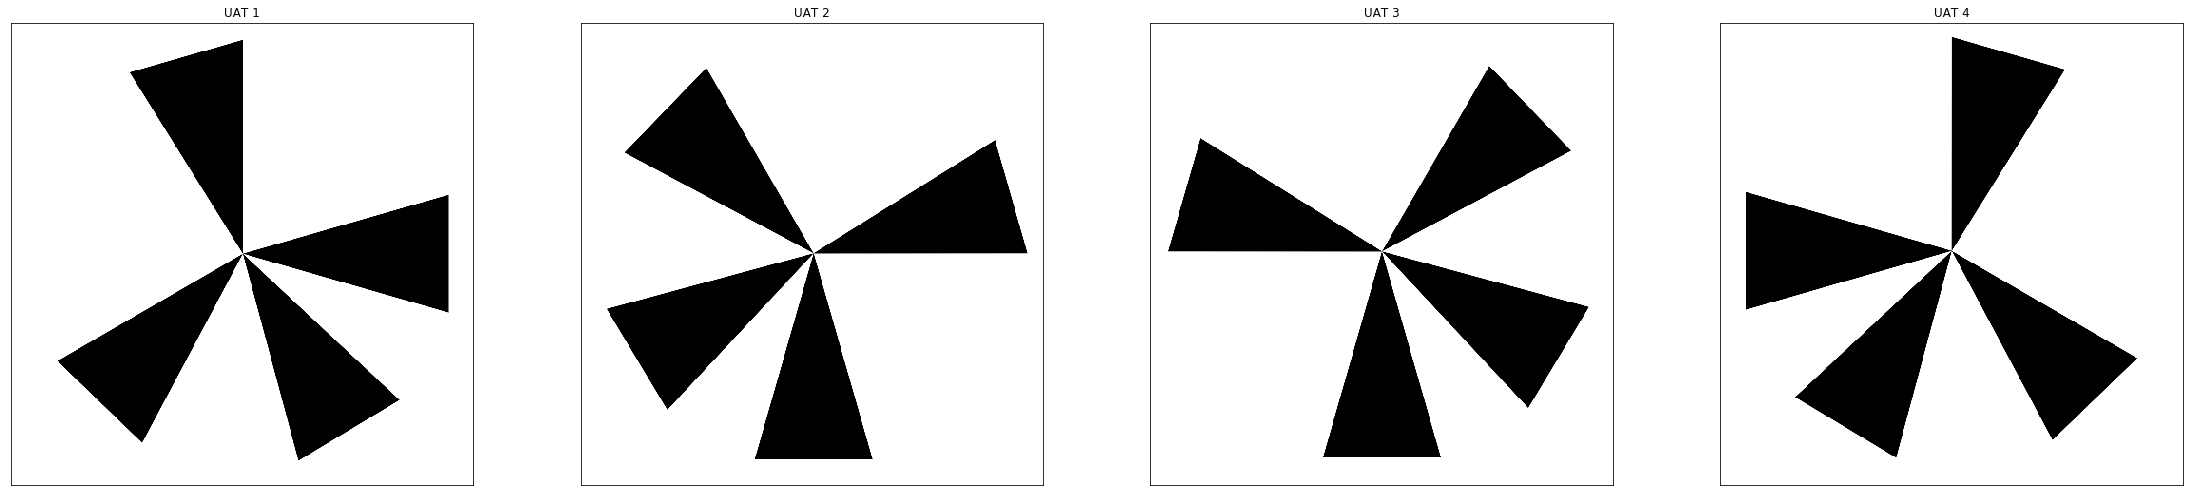

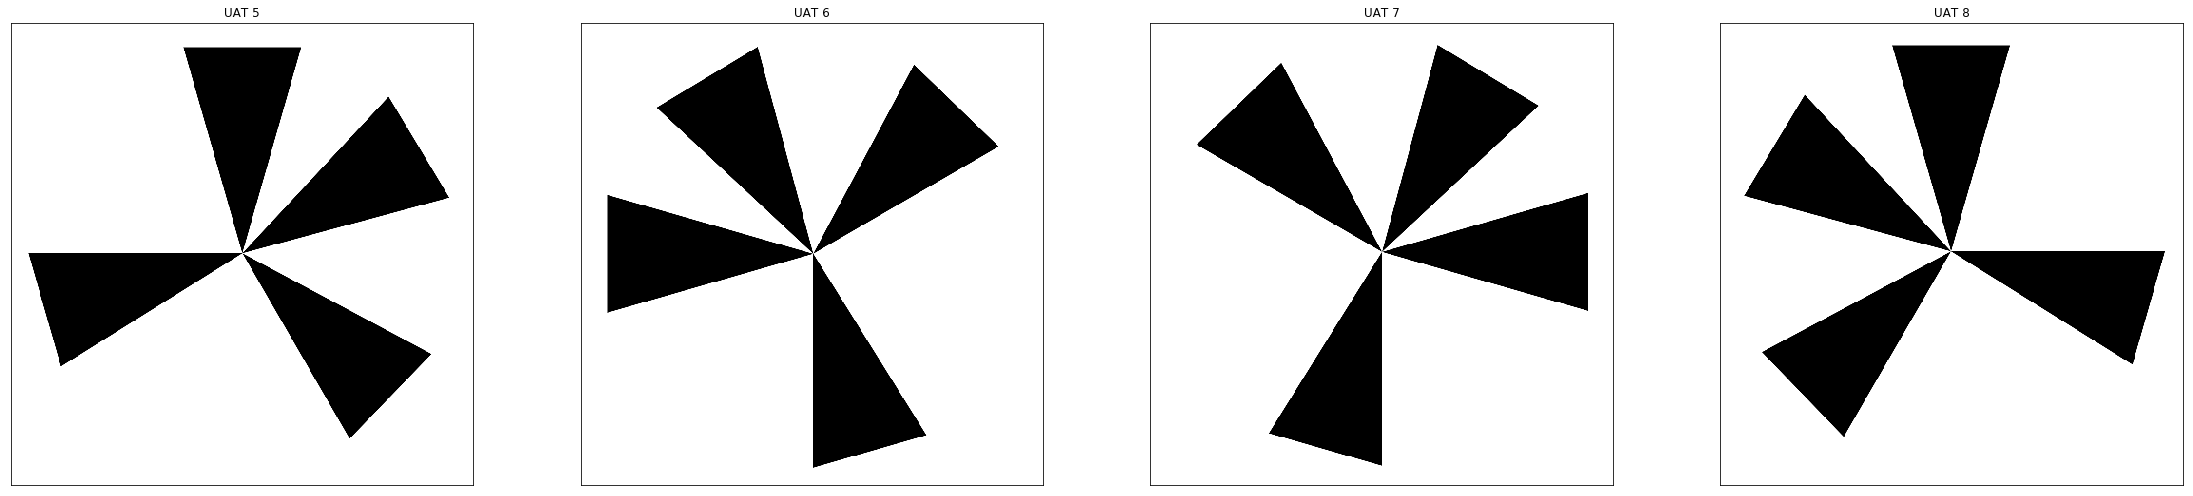

In [9]:
# open up high-res image which has array of 2x4 UATs
UAT_array_1_img = cv2.imread(paths.images_root+'/uat/UAT_array.png', cv2.IMREAD_GRAYSCALE)

scale_factor = 0.25
uat_h, uat_w = 1950*scale_factor, 1950*scale_factor

UAT_array_1_img = cv2.resize(UAT_array_1_img, None,fx=scale_factor,fy=scale_factor)
print(f"Image dims after scaling: {UAT_array_1_img.shape}")

uat_centerPts = [
 (1476, 1476),
 (3870, 1422),
 (6330, 1428),
 (8724, 1488),
 (1536, 3654),
 (3966, 3594),
 (6222, 3600),
 (8658, 3660)
]

uat_centerPts_scaled = list(tuple(int(i*scale_factor) for i in cp) for cp in uat_centerPts)

plot_lst = []
for idx, cp in enumerate(uat_centerPts):
    plot_lst.append((ip.sliceImage(UAT_array_1_img, uat_centerPts_scaled[idx], uat_h, uat_w), f"UAT {idx+1}"))

util.plot_imgs(plot_lst, max_cols = 4)

## OpenCV Template Match

#### Read in a source image and extract template, then make template a binary image

/Users/trafferty/data/images/uat/UAT2_with_clutter_01.png
template_img shape: (150, 150)


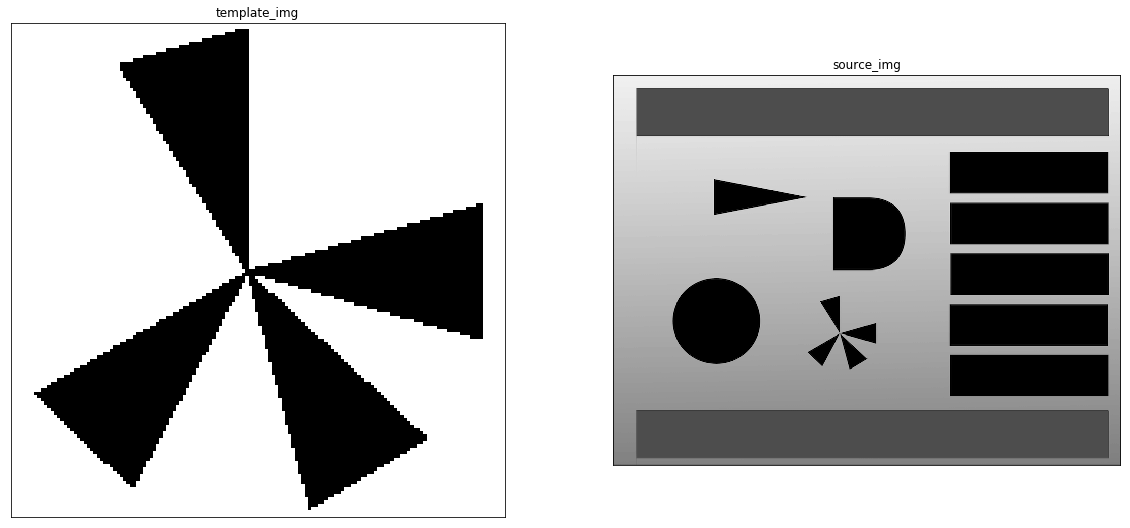

In [10]:
# UAT_num = 1
# UAT1_img = get_uat(UAT_array_1_img, UAT_num)

fname = "UAT2_with_clutter_01.png"
fpath = f"{paths.images_root}/uat/{fname}"
print(fpath)
source_img = cv2.imread(paths.images_root+'/uat/'+fname, cv2.IMREAD_GRAYSCALE)

cp = (450, 508)
h, w = 150, 150
template_img = ip.sliceImage(source_img, cp, h, w)
# make binary image
template_img = ((template_img > 100) * 255).astype("uint8")
print(f"template_img shape: {template_img.shape[::-1]}")

util.plot_imgs([(template_img,'template_img'), (source_img,'source_img')], max_cols = 3)

#### Use source and template image from above to try out different matchTemplate methods
- Also can adjust rotation of template image to get a feel for theta sensitivity

Desired location centerpoint is (450, 508)
cv2.TM_CCOEFF: found at (450, 508),  delta: (0, 0)  score: 115941584.000
cv2.TM_CCOEFF_NORMED: found at (450, 508),  delta: (0, 0)  score: 0.967
cv2.TM_CCORR: found at (76, 196),  delta: (-374, -312)  score: 590982080.000
cv2.TM_CCORR_NORMED: found at (450, 508),  delta: (0, 0)  score: 0.991
cv2.TM_SQDIFF: found at (76, 196),  delta: (-374, -312)  score: 332565696.000
cv2.TM_SQDIFF_NORMED: found at (76, 196),  delta: (-374, -312)  score: 0.482


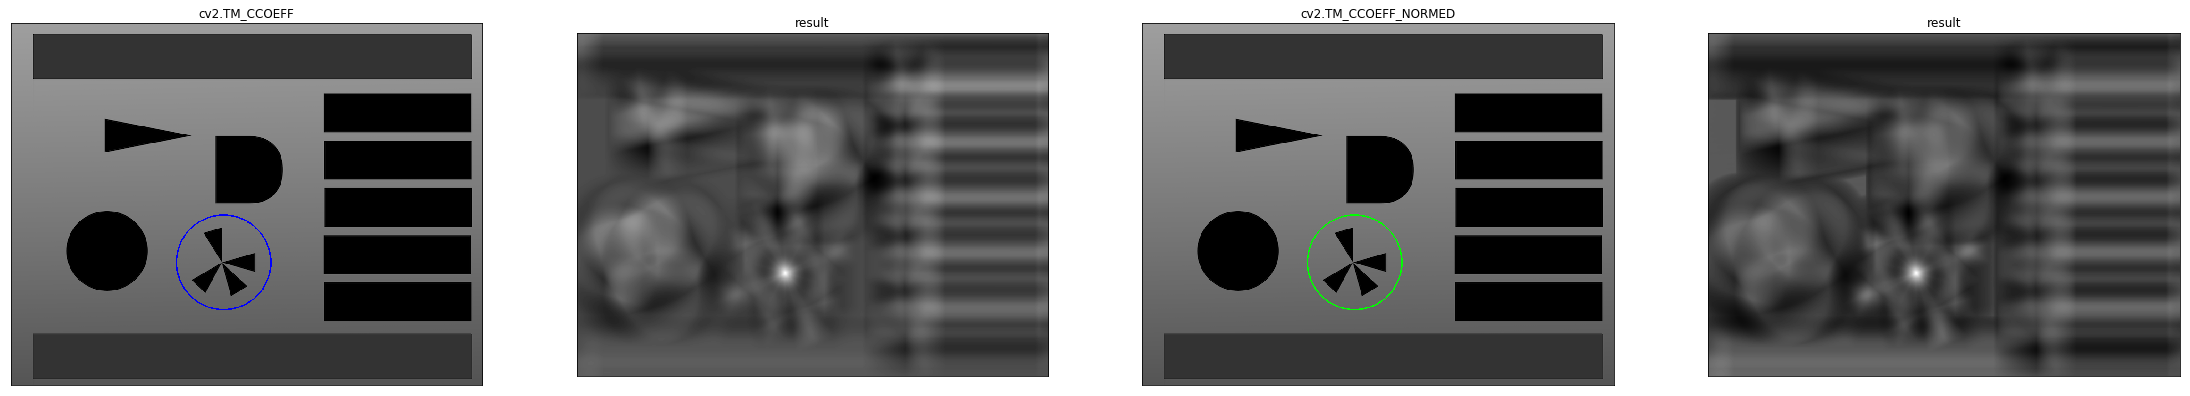

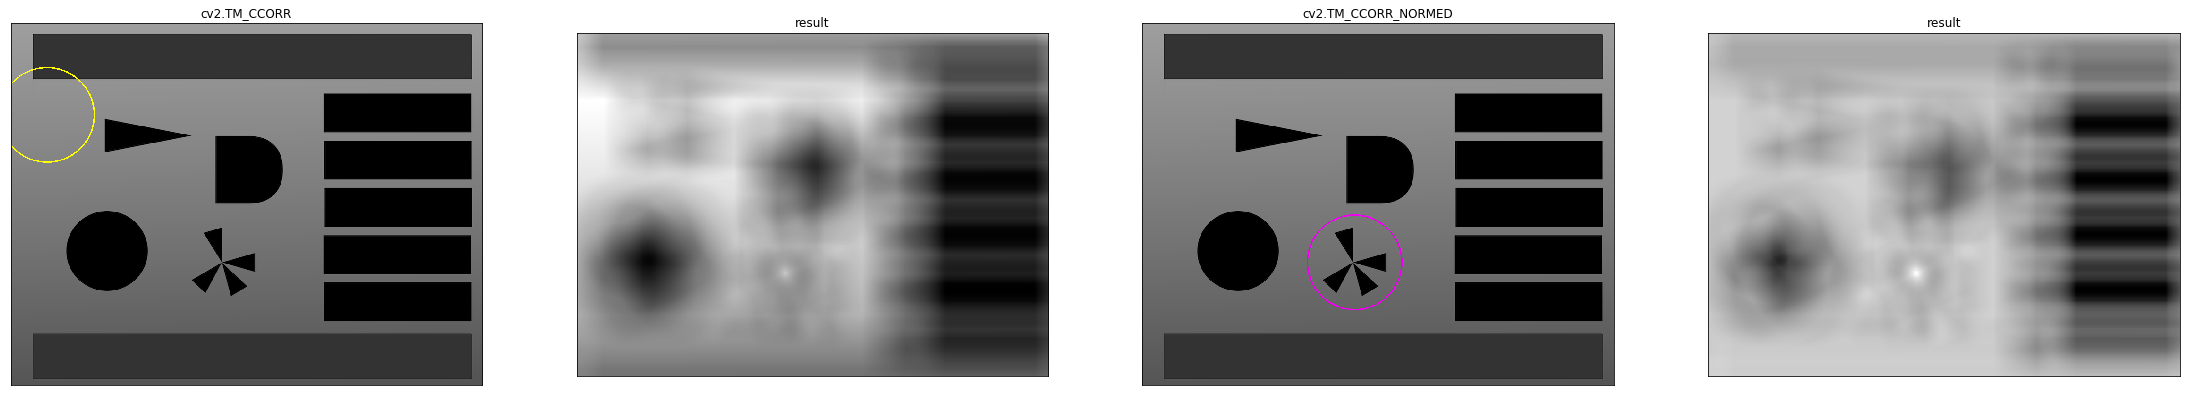

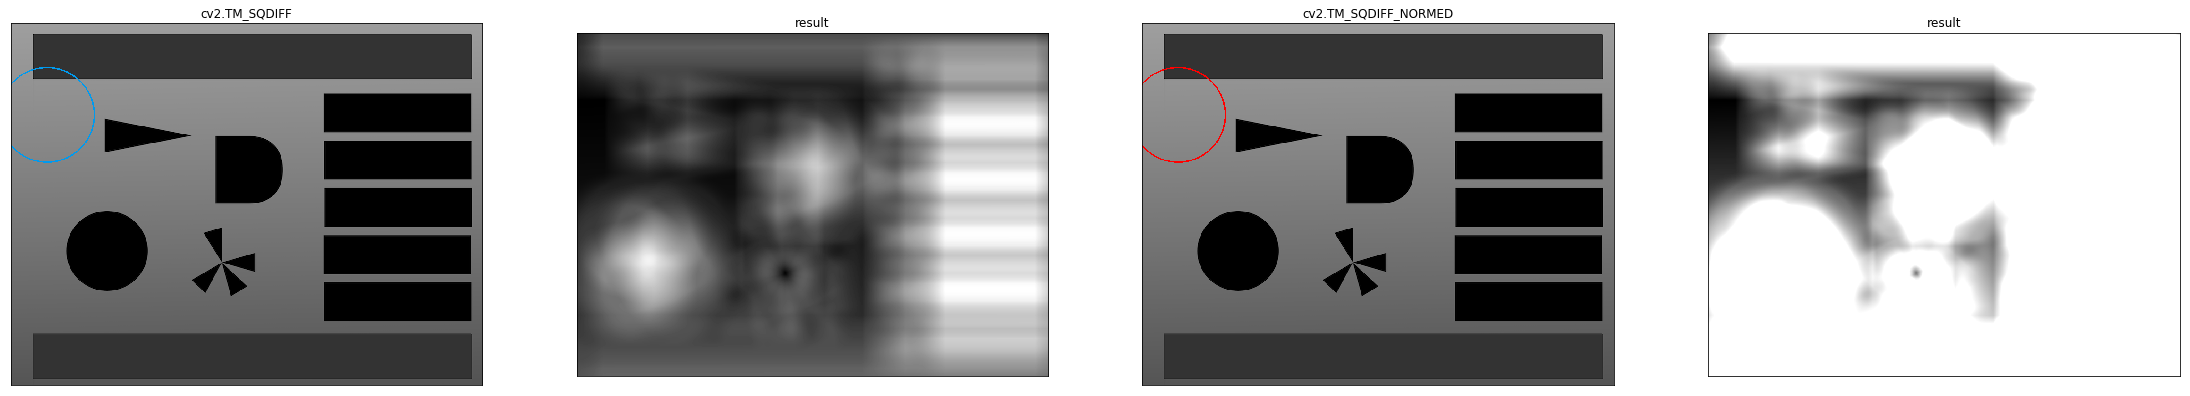

In [11]:
template_img = ((template_img > 100) * 255).astype("uint8")

template_img = ip.rotateImage(template_img.copy(), 0)
w, h = template_img.shape[::-1]

methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
marker_colors = [util.blue, util.green, util.yellow, util.magenta, util.orange, util.red]

print(f"Desired location centerpoint is {cp}")

plot_lst = []

for method_str, marker_color in zip(methods, marker_colors):
    method = eval(method_str)
    result = cv2.matchTemplate(source_img, template_img, method)
    #result8 = cv2.normalize(result, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_loc = min_loc
        top_val = min_val
    else:
        top_loc = max_loc
        top_val = max_val
    top_left = top_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    out_img = cv2.cvtColor(source_img.copy(),cv2.COLOR_GRAY2BGR)

    center_pt = (top_loc[0]+int(w/2), top_loc[1]+int(h/2))
    #cv2.rectangle(source_img,top_left, bottom_right, 255, 2)
    cv2.circle(out_img, center_pt, 100, marker_color, 2)
    
    deltaX, deltaY = (center_pt[0] - cp[0]), (center_pt[1] - cp[1])

    emphasis = util.RED if max(abs(deltaX), abs(deltaY)) > 0 else util.GREEN
    print(f"{method_str}: found at {center_pt}, {emphasis} delta: ({deltaX}, {deltaY}) {util.RESET} score: {top_val:.3f}")
# val, result = cv2.threshold(result, 0.01, 0, cv2.THRESH_TOZERO)
# result8 = cv2.normalize(result,None,0,255, cv2.NORM_MINMAX, cv2.CV_8U)

    plot_lst.append( (out_img, method_str) )
    plot_lst.append( (result, 'result') )
    
util.plot_imgs(plot_lst, max_cols = 4)
#util.plot_imgs([(template_img,'template_img'), (out_img,'source_img'), (result,'result8')], max_cols = 3)

#### From the above, TM_CCOEFF_NORMED method seems to work best.  Let's go with that for now.

### Let's look for multiple UAT from an image with UATs of different sizes and rotations
- Angles from -10 -> +10 degrees, scaling from 0.5x -> 2.0x
- Looks like if threshold set to 0.5, then it finds just about all UATs (not the small scaled ones)
- Threshold == 0.9: only finds UATs close to template
- THreshold == 0.75: finds a pretty good range 

template image: w=150, h=150
Rotation Test: Adding UAT at (200, 400) with rot -10.00 degrees
Rotation Test: Adding UAT at (500, 600) with rot -7.50 degrees
Rotation Test: Adding UAT at (800, 500) with rot -5.00 degrees
Rotation Test: Adding UAT at (200, 780) with rot -2.50 degrees
Rotation Test: Adding UAT at (340, 222) with rot 0.00 degrees
Rotation Test: Adding UAT at (1200, 300) with rot 2.50 degrees
Rotation Test: Adding UAT at (888, 855) with rot 5.00 degrees
Rotation Test: Adding UAT at (1244, 777) with rot 7.50 degrees
Rotation Test: Adding UAT at (605, 285) with rot 10.00 degrees
Scale Test: Adding UAT at (200, 400) with scale 0.50x
Scale Test: Adding UAT at (500, 600) with scale 0.69x
Scale Test: Adding UAT at (800, 500) with scale 0.88x
Scale Test: Adding UAT at (200, 780) with scale 1.06x
Scale Test: Adding UAT at (340, 222) with scale 1.25x
Scale Test: Adding UAT at (1200, 300) with scale 1.44x
Scale Test: Adding UAT at (888, 855) with scale 1.62x
Scale Test: Adding UAT at 

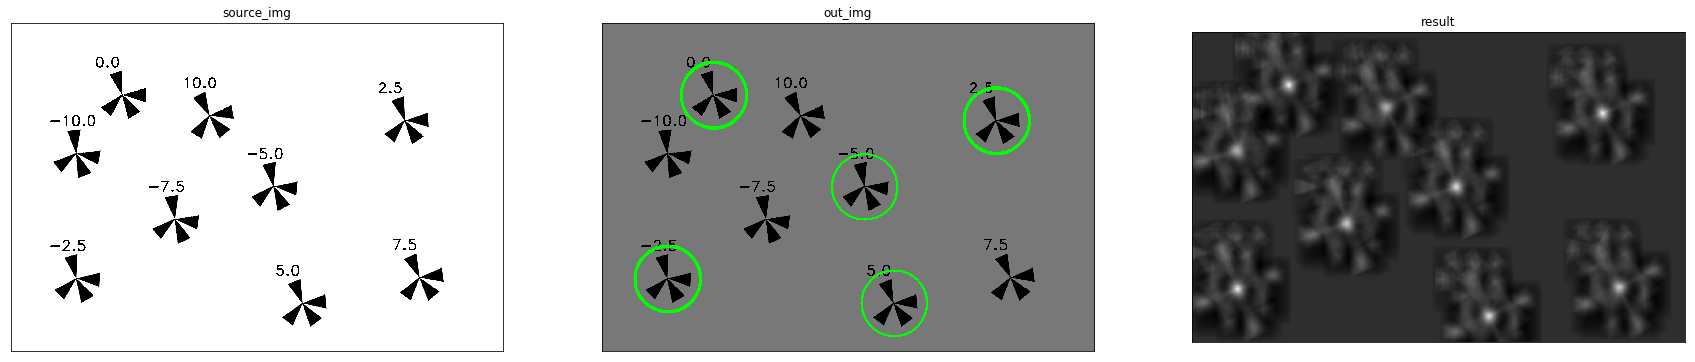

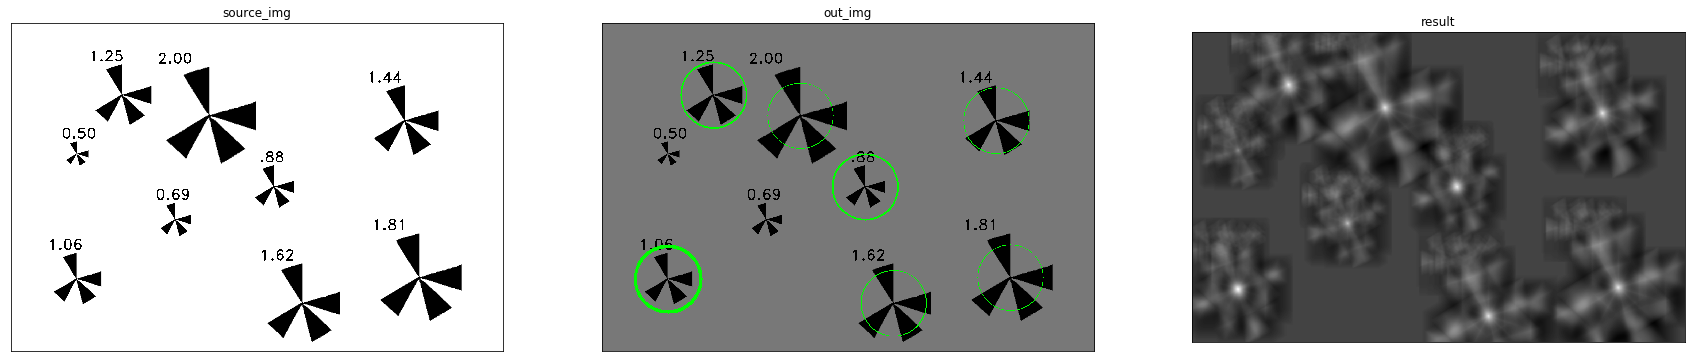

In [12]:
background_val = 120
threshold = 0.75

template_fname = 'UAT2_from_clutter_mono.png'
template_fpath = f"{paths.images_root}/uat/{template_fname}"
template_img = cv2.imread(template_fpath, cv2.IMREAD_GRAYSCALE)
w, h = template_img.shape[::-1]
print(f"template image: w={w}, h={h}")
source_base = np.ones((1000,1500), np.uint8)*background_val

mask = np.zeros((h+2, w+2), np.uint8)
template_img_filled = template_img.copy()
cv2.floodFill(template_img_filled, mask, (1,1), (background_val,)*3, (0,)*3, (255,)*3, 4)

plot_lst = []
locs = [(200, 400), (500, 600), (800, 500), (200, 780), (340, 222),
        (1200, 300), (888, 855), (1244, 777), (605, 285)]

angles = list(np.linspace(-10, 10, len(locs)))

# First try some different rotations:
source_img = source_base.copy()

for loc, ang_deg in zip(locs, angles):
    t_img = template_img_filled.copy()
    
    #ang_deg = random.randint(-8, 8)
    t_img = ip.rotateImage(t_img, ang_deg, background_val)
    
    s = ip.calcSlice(loc, h, w)
    source_img[s[0][0]:s[0][1], s[1][0]:s[1][1]] = t_img
    #source_img = ip.sp_noise(source_img, 0.03)
    
    print(f"Rotation Test: Adding UAT at {loc} with rot {ang_deg:.2f} degrees")
    cv2.putText(source_img, f"{ang_deg}", (s[1][0]-10, s[0][0]-10), cv2.FONT_HERSHEY_DUPLEX, 1.5, util.black, 2)

out_img = cv2.cvtColor(source_img.copy(),cv2.COLOR_GRAY2BGR)

method = cv2.TM_CCOEFF_NORMED
result = cv2.matchTemplate(source_img, template_img, method)

loc = np.where( result >= threshold)
for pt in zip(*loc[::-1]):
    cv2.circle(out_img, (pt[0] + int(w/2), pt[1] + int(h/2)), 100, util.green, 1)
    #ip.cross(out_img, (pt[0] + int(w/2), pt[1] + int(h/2)), 100, util.green, 1)

util.plot_imgs([(source_img, 'source_img'), (out_img, 'out_img'), (result, 'result')], max_cols = 3)

# Now try some different scales:
source_img = source_base.copy()

scales = list(np.linspace(0.5, 2.0, len(locs)))

for loc, scale in zip(locs, scales):
    t_img = template_img_filled.copy()
    
    #scale = random.uniform(0.5, 2.0)
    t_img = cv2.resize(t_img, None, fx=scale, fy=scale)
    w_scaled, h_scaled = t_img.shape[::-1]
    #print(w_scaled, h_scaled)

    s = ip.calcSlice(loc, h_scaled, w_scaled)
    #print(f"{s}: y: {abs(s[0][0]-s[0][1])}, x: {abs(s[1][0]-s[1][1])}")
    source_img[s[0][0]:s[0][1], s[1][0]:s[1][1]] = t_img
    #source_img = ip.sp_noise(source_img, 0.03)
    
    print(f"Scale Test: Adding UAT at {loc} with scale {scale:.2f}x")
    cv2.putText(source_img, f"{scale:.2f}", (s[1][0]-10, s[0][0]-10), cv2.FONT_HERSHEY_DUPLEX, 1.5, util.black, 2)

out_img = cv2.cvtColor(source_img.copy(),cv2.COLOR_GRAY2BGR)

method = cv2.TM_CCOEFF_NORMED
result = cv2.matchTemplate(source_img, template_img, method)

loc = np.where( result >= threshold)
for pt in zip(*loc[::-1]):
    cv2.circle(out_img, (pt[0] + int(w/2), pt[1] + int(h/2)), 100, util.green, 1)
    #ip.cross(out_img, (pt[0] + int(w/2), pt[1] + int(h/2)), 100, util.green, 1)

util.plot_imgs([(source_img, 'source_img'), (out_img, 'out_img'), (result, 'result')], max_cols = 3)

### Define some functions so we use the same flow for future cells

In [13]:
def find_object(source_img, template_img, method):
    result = cv2.matchTemplate(source_img, template_img, method)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
    if method == cv2.TM_SQDIFF_NORMED:
        top_loc = min_loc
        confidence = 1.0-min_val
    else:
        top_loc = max_loc
        confidence = max_val

    w, h = template_img.shape[::-1]
    center_pt = (top_loc[0]+int(w/2), top_loc[1]+int(h/2))
        
    return confidence, center_pt

def score_find_object(source_img, confidence, center_pt, debug=True):
    out_img = cv2.cvtColor(source_img.copy(),cv2.COLOR_GRAY2BGR)

    threshold1 = 0.75
    threshold2 = 0.5
    threshold3 = 0.25
    if confidence >= threshold1:
        cv2.circle(out_img, center_pt, 100, util.green, 2)
        cv2.putText(out_img, f"Found target: {center_pt}, score: {confidence:.3f}", (100, 100), cv2.FONT_HERSHEY_DUPLEX, 1.0, util.green, 2)
        if debug: print(f"Found target: {center_pt}, score: {confidence:.3f}")
    elif confidence >= threshold2:
        cv2.circle(out_img, center_pt, 100, util.orange, 2)
        cv2.putText(out_img, f"MAYBE found: {center_pt}, score: {confidence:.3f}", (100, 100), cv2.FONT_HERSHEY_DUPLEX, 1.0, util.orange, 2)
        if debug: print(f"MAYBE found: {center_pt}, score: {confidence:.3f}")
    elif confidence >= threshold3:
        cv2.circle(out_img, center_pt, 100, util.yellow, 2)
        cv2.putText(out_img, f"NOT SURE if found: {center_pt}, score: {confidence:.3f}", (100, 100), cv2.FONT_HERSHEY_DUPLEX, 1.0, util.yellow, 2)
        if debug: print(f"NOT SURE if found: {center_pt}, score: {confidence:.3f}")
    else:
        cv2.circle(out_img, center_pt, 100, util.red, 2)
        cv2.putText(out_img, f"Could not find target ({confidence:.3f}<{threshold}), {center_pt})", (100, 100), cv2.FONT_HERSHEY_DUPLEX, 1.0, util.red, 2)
        if debug: print(f"Could not find target")
    return out_img


### Let's try to find UAT in a bunch of different images, some with the target UAT, some without
- image 'noise' can be added using sp_noise.

NOT SURE if found: (716, 170), score: 0.289
NOT SURE if found: (714, 169), score: 0.287
Found target: (111, 203), score: 0.866
Found target: (525, 501), score: 0.809
Found target: (448, 509), score: 0.812
MAYBE found: (326, 260), score: 0.626
MAYBE found: (581, 129), score: 0.589
Found target: (695, 415), score: 0.895
NOT SURE if found: (714, 170), score: 0.288
NOT SURE if found: (718, 169), score: 0.286


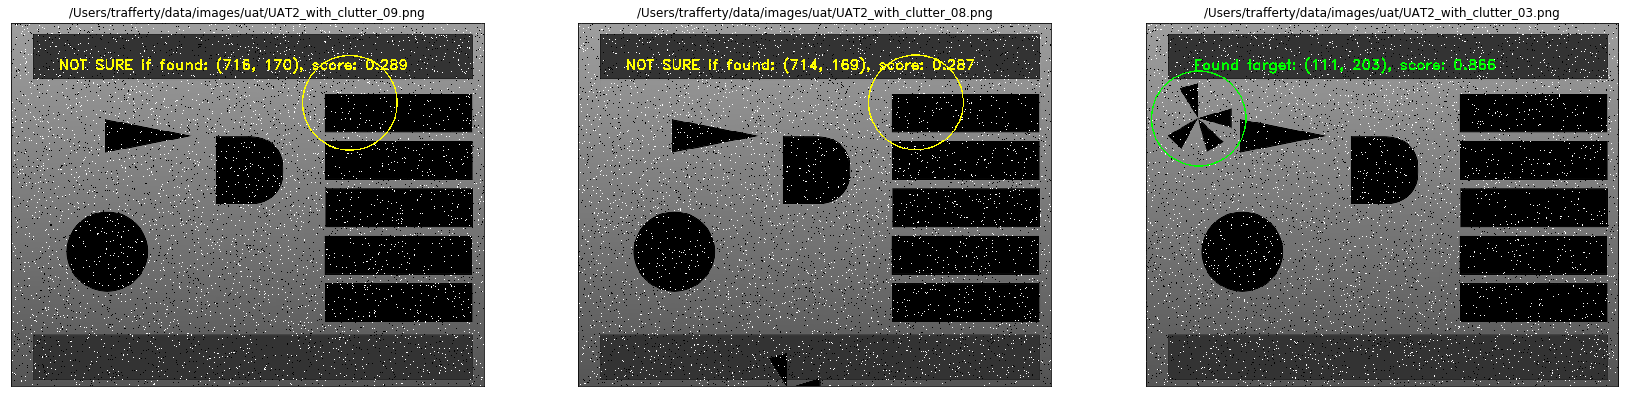

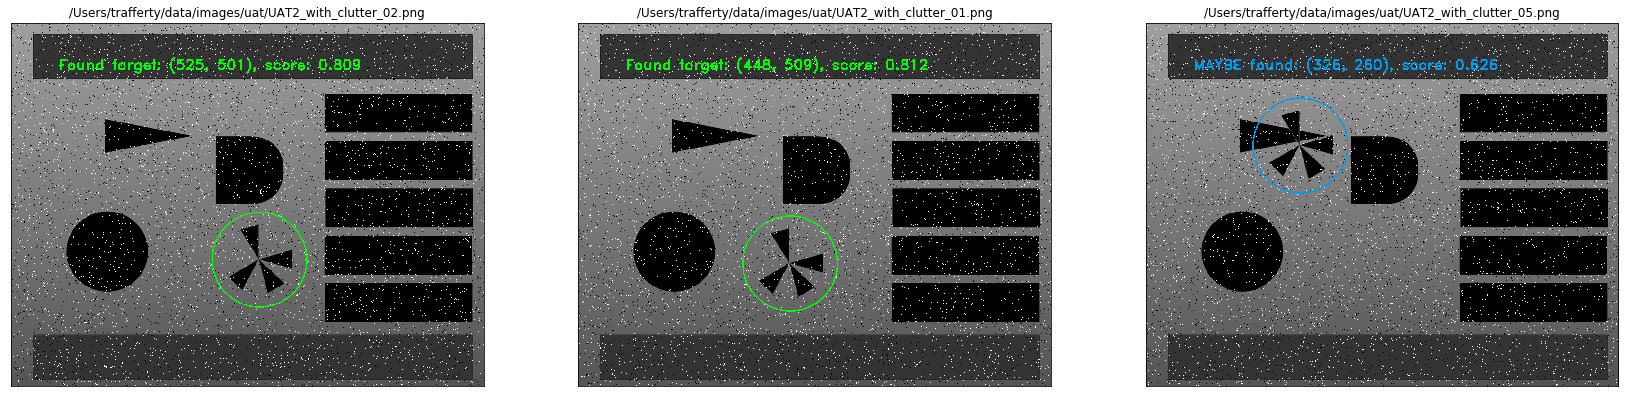

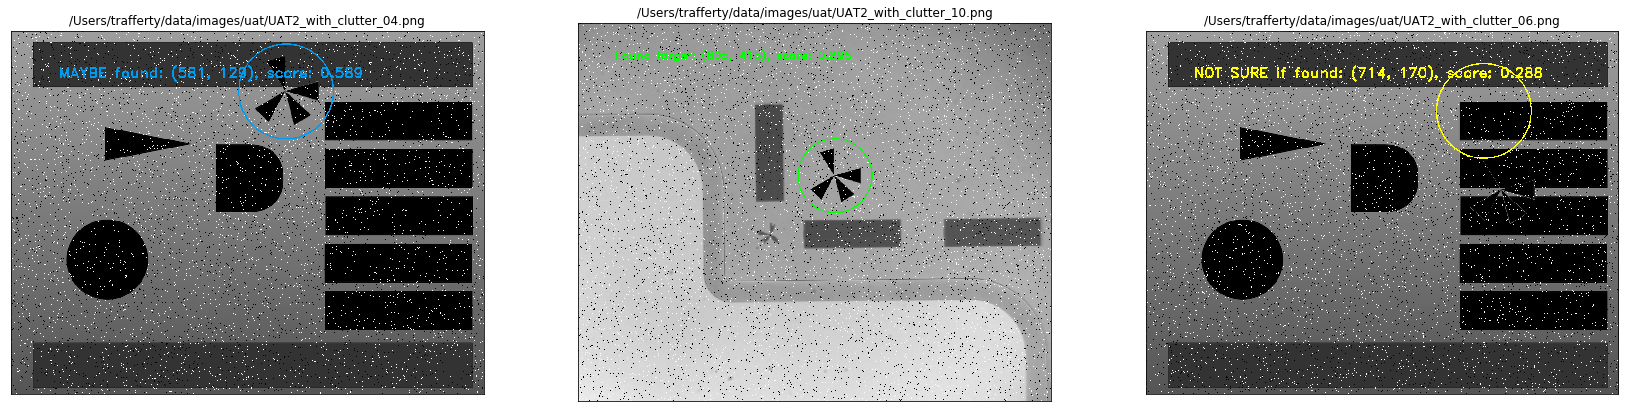

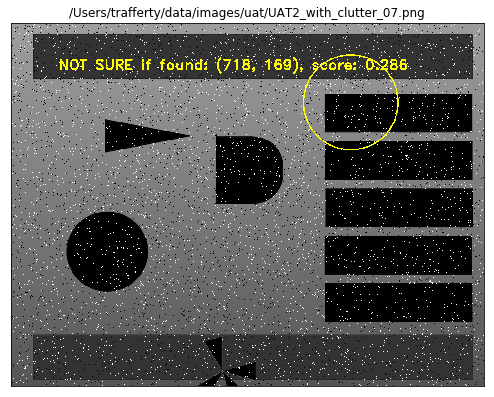

In [14]:
if False:
    # slice the target UAT out of a 'golden' image
    fname = "UAT2_with_clutter_01.png"
    fpath = f"{paths.images_root}/uat/{fname}"
    golden_source_img = cv2.imread(paths.images_root+'/uat/'+fname, cv2.IMREAD_GRAYSCALE)
    cp = (450, 508)
    h_w = 150
    template_img = ip.sliceImage(golden_source_img, cp, h_w, h_w)
else:
    # read in the target UAT
    template_fname = 'UAT2_from_clutter_mono.png'
    template_fpath = f"{paths.images_root}/uat/{template_fname}"
    template_img = cv2.imread(template_fpath, cv2.IMREAD_GRAYSCALE)
w, h = template_img.shape[::-1]

source_img_list = glob.glob(f"{paths.images_root}/uat/UAT2_with_clutter_*.png")

plot_lst = []

for source_img_path in source_img_list:
    source_img = cv2.imread(source_img_path, cv2.IMREAD_GRAYSCALE)
    
    source_img = ip.sp_noise(source_img, 0.02)
    
    method = cv2.TM_CCOEFF_NORMED
    confidence, center_pt = find_object(source_img, template_img, method)
    out_img = score_find_object(source_img, confidence, center_pt)
    
    plot_lst.append( (out_img, source_img_path) )
    
util.plot_imgs(plot_lst, max_cols = 3)

### Synthesize some images and broadcast the UAT at different locs, then try to find them
- again, image noise can/should be added 
- location found should equal location placed

template image: w=150, h=150
Found target: (200, 400), score: 0.824
  delta: (0, 0) 
Found target: (500, 600), score: 0.808
  delta: (0, 0) 
Found target: (800, 500), score: 0.816
  delta: (0, 0) 
Found target: (100, 880), score: 0.822
  delta: (0, 0) 
Found target: (340, 222), score: 0.815
  delta: (0, 0) 


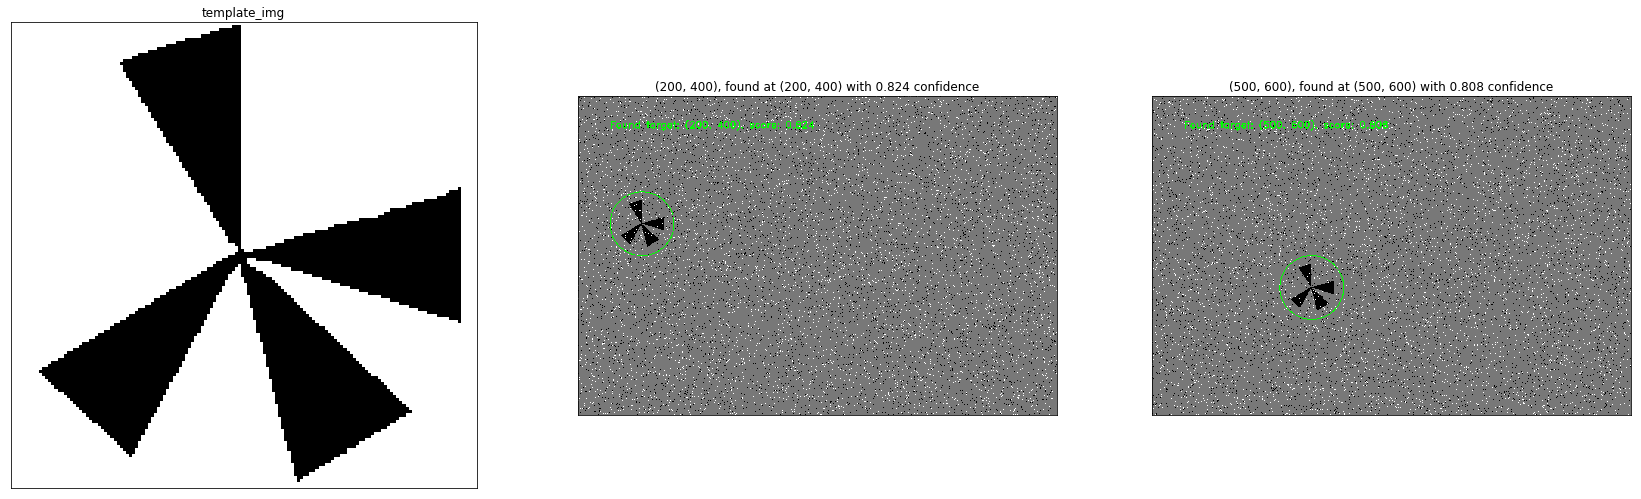

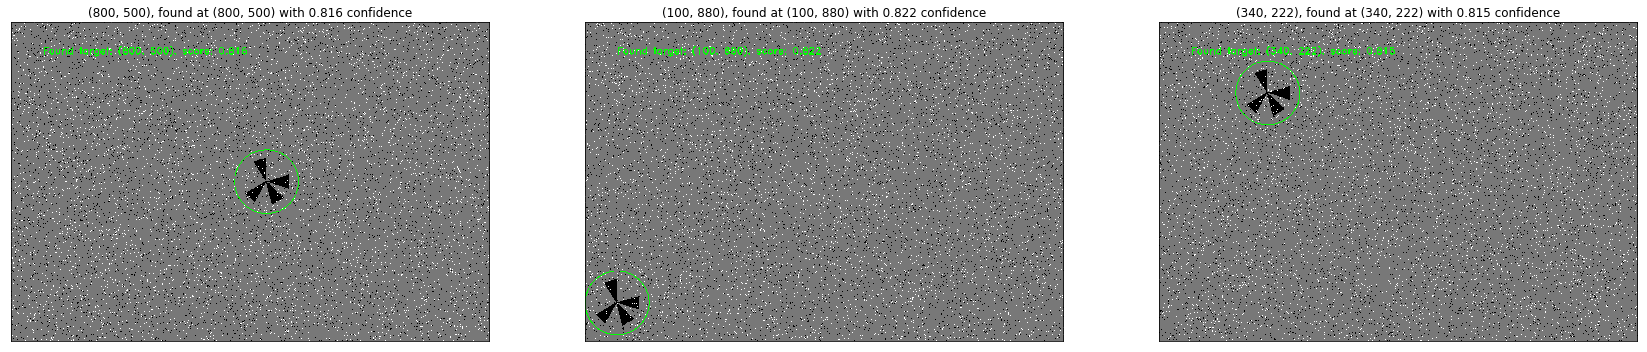

In [15]:
background_val = 120
template_fname = 'UAT2_from_clutter_mono.png'
template_fpath = f"{paths.images_root}/uat/{template_fname}"
template_img = cv2.imread(template_fpath, cv2.IMREAD_GRAYSCALE)
w, h = template_img.shape[::-1]
print(f"template image: w={w}, h={h}")
source_base = np.ones((1000,1500), np.uint8)*background_val

mask = np.zeros((h+2, w+2), np.uint8)
template_img_filled = template_img.copy()
cv2.floodFill(template_img_filled, mask, (1,1), (background_val,)*3, (0,)*3, (255,)*3, 4)

# s = ip.calcSlice((200, 400), h, w)
# print(s)
# source_base[s[0][0]:s[0][1], s[1][0]:s[1][1]] = template_img

plot_lst = []
plot_lst.append( (template_img, "template_img")) 
locs = [(200, 400), (500, 600), (800, 500), (100, 880), (340, 222)]
for loc in locs:
    source_img = source_base.copy()
    
    s = ip.calcSlice(loc, h, w)
    source_img[s[0][0]:s[0][1], s[1][0]:s[1][1]] = template_img_filled
    source_img = ip.sp_noise(source_img, 0.03)
    
    method = cv2.TM_CCOEFF_NORMED
    confidence, center_pt = find_object(source_img, template_img, method)
    out_img = score_find_object(source_img, confidence, center_pt)
    
    emphasis = util.RED if center_pt != loc else util.GREEN
    print(f" {emphasis} delta: {center_pt[0]-loc[0], center_pt[1]-loc[1]} {util.RESET}")

    plot_lst.append( (out_img, f"{loc}, found at {center_pt} with {confidence:.3f} confidence") )
    
util.plot_imgs(plot_lst, max_cols = 3)


### Let's see how sensitive we are to noise...

template image: w=150, h=150
noise level: 0.00 - delta: (0, 0), conf: 1.000
noise level: 0.02 - delta: (0, 0), conf: 0.869
noise level: 0.04 - delta: (0, 0), conf: 0.698
noise level: 0.06 - delta: (0, 0), conf: 0.526
noise level: 0.08 - delta: (0, 0), conf: 0.390
noise level: 0.10 - delta: (0, 0), conf: 0.283
noise level: 0.12 - delta: (0, 0), conf: 0.203
noise level: 0.14 - delta: (0, 0), conf: 0.134
noise level: 0.16 - delta: (0, 0), conf: 0.088
noise level: 0.18 - delta: (0, 0), conf: 0.053
noise level: 0.20 - delta: (-1, -4), conf: 0.046
noise level: 0.22 - delta: (1, 1), conf: 0.032


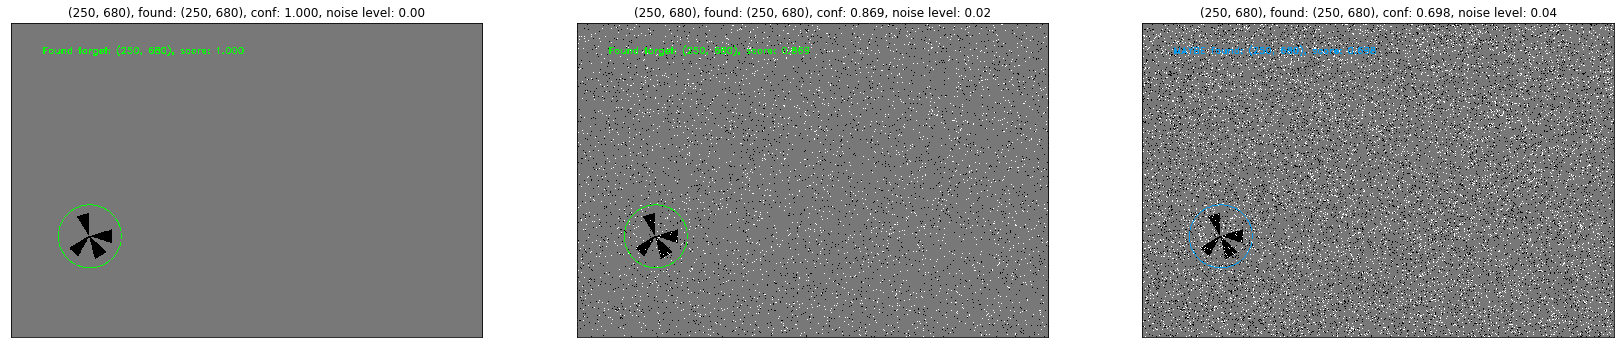

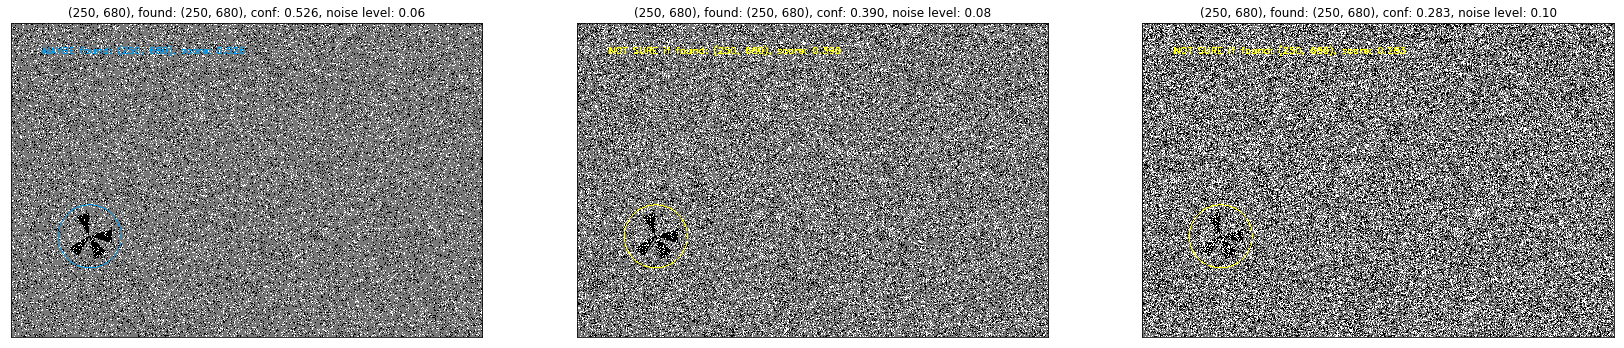

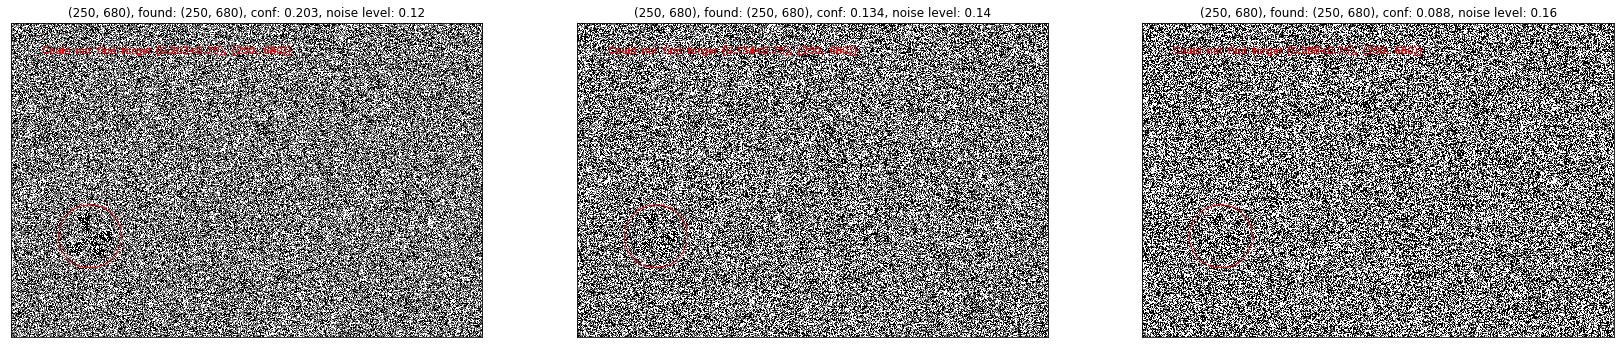

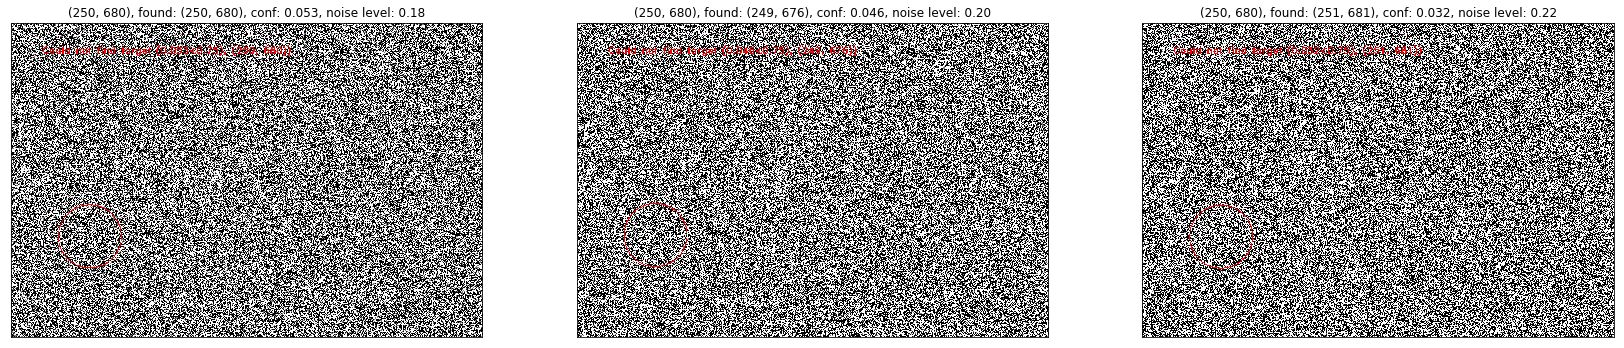

In [16]:
background_val = 120
template_fname = 'UAT2_from_clutter_mono.png'
template_fpath = f"{paths.images_root}/uat/{template_fname}"
template_img = cv2.imread(template_fpath, cv2.IMREAD_GRAYSCALE)
w, h = template_img.shape[::-1]
print(f"template image: w={w}, h={h}")
source_base = np.ones((1000,1500), np.uint8)*background_val

mask = np.zeros((h+2, w+2), np.uint8)
template_img_filled = template_img.copy()
cv2.floodFill(template_img_filled, mask, (1,1), (background_val,)*3, (0,)*3, (255,)*3, 4)

source_img = source_base.copy()

loc = (250, 680)
s = ip.calcSlice(loc, h, w)
source_img[s[0][0]:s[0][1], s[1][0]:s[1][1]] = template_img_filled

plot_lst = []
for x in list(np.arange(0.0, 0.24, 0.02)):
    source_img = ip.sp_noise(source_img, x)
    
    method = cv2.TM_CCOEFF_NORMED
    confidence, center_pt = find_object(source_img, template_img, method)
    out_img = score_find_object(source_img, confidence, center_pt, False)
    
    emphasis = util.RED if center_pt != loc else util.GREEN
    print(f"noise level: {x:.2f} - {emphasis}delta: {center_pt[0]-loc[0], center_pt[1]-loc[1]}{util.RESET}, conf: {confidence:.3f}")

    plot_lst.append( (out_img, f"{loc}, found: {center_pt}, conf: {confidence:.3f}, noise level: {x:.2f}") )
    
util.plot_imgs(plot_lst, max_cols = 3)


### For testing purposes, here's a snippit to produce a video of UATs moving around

In [45]:
background_val = 120
video_fpath = f"{paths.tmp_dir}/UAT_test2.avi"
template_fname = 'UAT2_from_clutter_mono.png'
template_fpath = f"{paths.images_root}/uat/{template_fname}"
template_img = cv2.imread(template_fpath, cv2.IMREAD_GRAYSCALE)
w, h = template_img.shape[::-1]
print(f"template image: w={w}, h={h}")
frame_size = (1000,1500)
source_base = np.ones(frame_size, np.uint8)*background_val

mask = np.zeros((h+2, w+2), np.uint8)
template_img_filled = template_img.copy()
cv2.floodFill(template_img_filled, mask, (1,1), (background_val,)*3, (0,)*3, (255,)*3, 4)

fps = 1
image_repeats = 100

video_out = cv2.VideoWriter(video_fpath, cv2.VideoWriter_fourcc(*'DIV3'), fps, (frame_size[1],frame_size[0]))

#locs = [(200, 400), (500, 600), (800, 500), (100, 880), (340, 222), (1200, 800), (180, 645)]
#locs = [(500, 600)]
locs = [ (random.randint(175, 1325), random.randint(175, 825)) for (x) in range(15) ]
for loc in locs:
    print("Adding loc:", loc)
    source_img = source_base.copy()
    
    s = ip.calcSlice(loc, h, w)
    source_img[s[0][0]:s[0][1], s[1][0]:s[1][1]] = template_img_filled
    source_img = ip.sp_noise(source_img, 0.01)

    source_img_color = cv2.cvtColor(source_img, cv2.COLOR_GRAY2BGR)
    for x in range(image_repeats):
        video_out.write(source_img_color)

video_out.release()

template image: w=150, h=150
Adding loc: (1316, 257)
Adding loc: (933, 722)
Adding loc: (1204, 665)
Adding loc: (1276, 667)
Adding loc: (580, 493)
Adding loc: (1102, 638)
Adding loc: (359, 338)
Adding loc: (1300, 224)
Adding loc: (1151, 275)
Adding loc: (321, 575)
Adding loc: (797, 775)
Adding loc: (444, 182)
Adding loc: (369, 724)
Adding loc: (511, 244)
Adding loc: (562, 650)


In [33]:
[ (random.randint(175, 1325), random.randint(175, 825)) for (x) in range(5) ]

[(845, 864), (786, 236), (398, 501), (532, 368), (727, 1281)]

## Scikit Image Match template

In [18]:
for idx, cp in enumerate(uat_centerPts):
    cv2.imwrite(f"{paths.images_root}/uat/UAT_{idx+1}.png", get_uat(UAT_array_1_img, idx))


NameError: name 'get_uat' is not defined

In [ ]:
#UAT_array_1_img = cv2.imread(paths.images_root+'/uat/UAT_array_diff_sizes.png', cv2.IMREAD_GRAYSCALE)


UAT_num = 3
UAT1_img = get_uat(UAT_array_1_img, UAT_num)

result = match_template(UAT_array_1_img, UAT1_img)
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]

print(f"Coords: {uat_centerPts[UAT_num-1]}")
print(f"Found: ({x}, {y})")

In [ ]:
fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3, sharex=ax2, sharey=ax2)

ax1.imshow(UAT1_img, cmap=plt.cm.gray)
ax1.set_axis_off()
ax1.set_title('UAT1_img')

ax2.imshow(UAT_array_1_img, cmap=plt.cm.gray)
ax2.set_axis_off()
ax2.set_title('UAT_array_1_img')
# highlight matched region
hcoin, wcoin = UAT1_img.shape
rect = plt.Rectangle((x, y), wcoin, hcoin, edgecolor='r', facecolor='none')
ax2.add_patch(rect)

ax3.imshow(result)
ax3.set_axis_off()
ax3.set_title('`match_template`\nresult')
# highlight matched region
ax3.autoscale(False)
ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

plt.show()

In [ ]:
from skimage import transform as tf

In [ ]:
img1 = UAT_array_1_img
img2 = tf.rotate(img1, 180)
tform = tf.AffineTransform(scale=(1.3, 1.1), rotation=0.5,
                           translation=(0, 0))
img3 = tf.warp(img2, tform)
util.plot_imgs([(img1,'img1'), (img2,'img2'), (img3,'img3')], max_cols = 3)

In [ ]:
UAT_num = 2
UAT1_img = get_uat(UAT_array_1_img, UAT_num)

result = match_template(img3, UAT1_img)
ij = np.unravel_index(np.argmax(result), result.shape)
x, y = ij[::-1]

print(f"Coords: {uat_centerPts[UAT_num-1]}")
print(f"Found: ({x}, {y})")

In [ ]:
fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3, sharex=ax2, sharey=ax2)

ax1.imshow(UAT1_img, cmap=plt.cm.gray)
ax1.set_axis_off()
ax1.set_title('UAT1_img')

ax2.imshow(img3, cmap=plt.cm.gray)
ax2.set_axis_off()
ax2.set_title('UAT_array_1_img')
# highlight matched region
hcoin, wcoin = UAT1_img.shape
rect = plt.Rectangle((x, y), wcoin, hcoin, edgecolor='r', facecolor='none')
ax2.add_patch(rect)
ax3.autoscale(False)

ax3.imshow(result)
ax3.set_axis_off()
ax3.set_title('`match_template`\nresult')
# highlight matched region
ax3.autoscale(False)
ax3.plot(x, y, 'o', markeredgecolor='r', markerfacecolor='none', markersize=10)

plt.show()

In [ ]:
from skimage.feature import (match_descriptors, corner_harris,
                             corner_peaks, ORB, plot_matches)

In [ ]:
UAT_num = 1
UAT_img = get_uat(UAT_array_1_img, UAT_num)

descriptor_extractor = ORB(n_keypoints=200)

descriptor_extractor.detect_and_extract(UAT_img)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

In [ ]:
fname = 'UAT1_with_clutter.png'
source_img = cv2.imread(paths.images_root+'/uat/'+fname, cv2.IMREAD_GRAYSCALE)

descriptor_extractor.detect_and_extract(source_img)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

fig, ax = plt.subplots(nrows=1, ncols=1)

plt.gray()

plot_matches(ax, UAT_img, source_img, keypoints1, keypoints2, matches12)
ax.axis('off')
ax.set_title(f"UAT {UAT_num} in image {fname}")

plt.show()

In [ ]:
matches12